# Fast Training of Support Vector Machines for Survival Analysis

This document demonstrates how to use the efficient implementation of *Survival Support Vector Machines* as proposed in

> Pölsterl, S., Navab, N., and Katouzian, A.,
> *Fast Training of Support Vector Machines for Survival Analysis*,
> Machine Learning and Knowledge Discovery in Databases: European Conference,
> ECML PKDD 2015, Porto, Portugal,
> Lecture Notes in Computer Science, vol. 9285, pp. 243-259 (2015)

The source code and installation instructions are available at https://github.com/sebp/scikit-survival.

The main class of interest is ``sksurv.svm.FastSurvivalSVM``, which implements the different optimizers for training
a Survival Support Vector Machine. Training data consists of $n$ triplets $(\mathbf{x}_i, y_i, \delta_i)$, where
$\mathbf{x}_i$ is a $d$-dimensional feature vector, $y_i > 0$ the survival time or time of censoring, and $\delta_i \in \{0,1\}$ the binary event indicator. Using the training data, the objective is to minimize the following function:

\begin{equation}
 \arg \min_{\mathbf{w}, b} \frac{1}{2} \mathbf{w}^T \mathbf{w}+ \frac{\alpha}{2} \left[
 r \sum_{i,j \in \mathcal{P}}
  \max(0, 1 - (\mathbf{w}^T \mathbf{x}_i - \mathbf{w}^T \mathbf{x}_j))^2
+ (1 - r) \sum_{i=0}^n \left( \zeta_{\mathbf{w},b} (y_i, x_i, \delta_i) \right)^2
\right]
\end{equation}

\begin{equation}
\zeta_{\mathbf{w},b} (y_i, \mathbf{x}_i, \delta_i) =
\begin{cases}
  \max(0, y_i - \mathbf{w}^T \mathbf{x}_i - b) & \text{if $\delta_i = 0$,} \\
 y_i - \mathbf{w}^T \mathbf{x}_i - b & \text{if $\delta_i = 1$,} \\
\end{cases}
\end{equation}

\begin{equation}
\mathcal{P} = \{ (i, j)~|~y_i > y_j \land \delta_j = 1 \}_{i,j=1,\dots,n}
\end{equation}

The hyper-parameter $\alpha > 0$ determines the amount of regularization to apply: a smaller value increases the amount of regularization and a higher value reduces the amount of regularization. The hyper-parameter $r \in [0; 1]$ determines the trade-off between the ranking objective and the regresson objective. If $r = 1$ it reduces to the ranking objective, and if $r = 0$ to the regression objective. If the regression objective is used, it is advised to log-transform the survival/censoring time first.

In this example, I'm going to use the ranking objective ($r = 1$) and grid search to determine the best setting for the hyper-parameter $\alpha$.

The class ``sksurv.svm.FastSurvivalSVM`` adheres to interfaces used in [scikit-learn](http://scikit-learn.org) and thus it is possible to combine it with auxiliary classes and functions from scikit-learn. Here, I'm going to use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.module_selection.GridSearchCV.html) to determine which set hyper-parameters performs best for the Veteran's Lung Cancer data. Since, we require an event indicator $\delta_i$, which is boolean, and the survival/censoring time $y_i$ for training, we have to create a structured array that contains both information.

But first, we have to import the classes we are going to use.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

sns.set_style("whitegrid")

Next, load data of the *Veteran's Administration Lung Cancer Trial* from disk and convert it to numeric values. The data consists of 137 patients and 6 features. The  primary  outcome  measure  was  death (`Status`, `Survival_in_days`).
The original data can be retrieved from http://lib.stat.cmu.edu/datasets/veteran.

Note that it does not matter how you name the fields corresponding to the event indicator and time, as long as the event indicator comes first.

In [2]:
data_x, y = load_veterans_lung_cancer()
x = encode_categorical(data_x)

Now, we are essentially ready to start training, but before let's determine what the amount of censoring for this data is and plot the survival/censoring times.

In [3]:
n_censored = y.shape[0] - y["Status"].sum()
print("%.1f%% of records are censored" % (n_censored / y.shape[0] * 100))

6.6% of records are censored


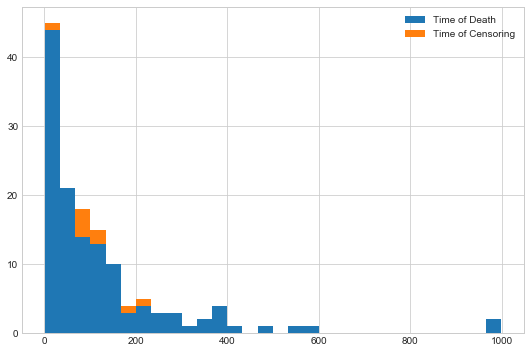

In [4]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((y["Survival_in_days"][y["Status"]],
                               y["Survival_in_days"][~y["Status"]]),
                              bins=30, stacked=True)
plt.legend(patches, ["Time of Death", "Time of Censoring"])

First, we need to create an initial model with default parameters that is subsequently used in the grid search. We are going to use a Red-Black tree to speed up optimization.

In [5]:
estimator = FastSurvivalSVM(optimizer="rbtree", max_iter=1000, tol=1e-6, random_state=0)

Next, we define a function for evaluating the performance of models during grid search. We use Harrell's concordance index.

In [6]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y['Status'], y['Survival_in_days'], prediction)
    return result[0]

The last part of the setup specifies the set of parameters we want to try and how many repetitions of training and testing we want to perform for each parameter setting. In the end, the parameters that on average peformed best across all test sets (200 in this case) are selected. [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) can leverage multiple cores by evaluating multiple parameter settings concurrently (I use 4 jobs in this example).

In [7]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(n_splits=200, test_size=0.5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model,
                   n_jobs=4, iid=False, refit=False,
                   cv=cv)

Finally, start the hyper-parameter search. This can take a while since a total of ``13 * 200 = 2600`` fits have to be evaluated.

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(x, y)

Let's check what is the best average performance across 200 random train/test splits we got and the corresponding hyper-parameters.

In [9]:
gcv.best_score_, gcv.best_params_

(0.718221596570157, {'alpha': 0.00390625})

Finally, we retrieve all 200 test scores for each parameter setting and visualize their distribution by box plots.

In [10]:
def plot_performance(gcv):
    n_splits = gcv.cv.n_splits
    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []
    for i, params in enumerate(gcv.cv_results_["params"]):            
        name = "%.5f" % params["alpha"]
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_["split%d_test_score" % j][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)
    df = pandas.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

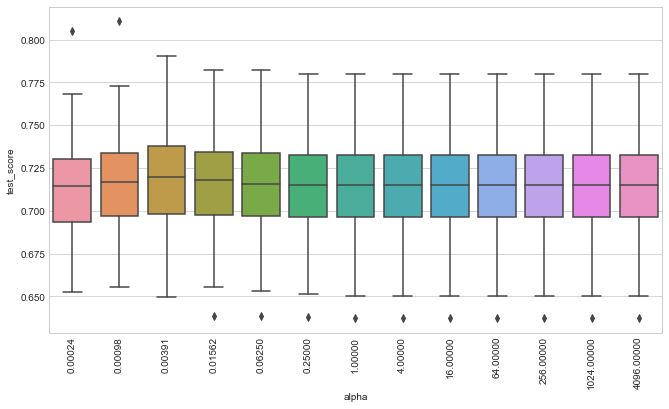

In [11]:
plot_performance(gcv)

# Kernel Survival Support Vector Machine

This section demonstrates how to use the efficient implementation of *Kernel Survival Support Vector Machines* as proposed in

> Pölsterl, S., Navab, N., and Katouzian, A.,
> *An Efficient Training Algorithm for Kernel Survival Support Vector Machines*
> 4th Workshop on Machine Learning in Life Sciences,
> 23 September 2016, Riva del Garda, Italy

As kernel we are going to use the clinical kernel, because it distinguishes between continuous, ordinal, and nominal attributes.

In [12]:
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.kernels import clinical_kernel

To use `GridSearchCV` with a custom kernel, we need to pre-compute the squared kernel matrix and pass it to `GridSearchCV.fit` later. It would also be possible to construct `FastKernelSurvivalSVM` with `kernel="rbf"` (or any other built-in kernel), which does not require pre-computing the kernel matrix.

In [13]:
kernel_matrix = clinical_kernel(data_x)
kssvm = FastKernelSurvivalSVM(optimizer="rbtree", kernel="precomputed", random_state=0)

In [14]:
kgcv = GridSearchCV(kssvm, param_grid, score_survival_model,
                    n_jobs=4, iid=False, refit=False,
                    cv=cv)

In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
kgcv = kgcv.fit(kernel_matrix, y)

Now, print the best average concordance index the corresponding parameters.

In [16]:
kgcv.best_score_, kgcv.best_params_

(0.7071426137273039, {'alpha': 0.015625})

Finally, we visualize the distribution of test scores obtained via cross-validation.

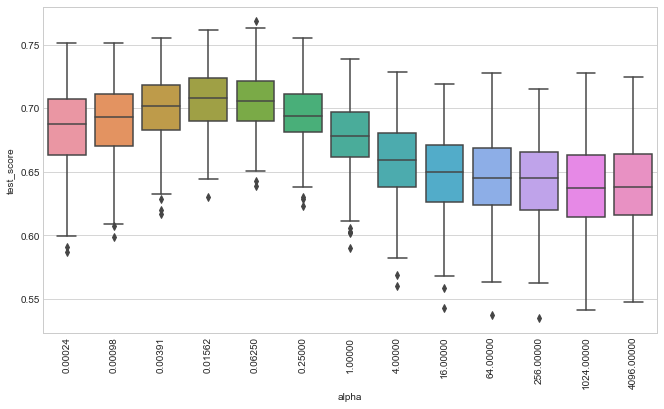

In [17]:
plot_performance(kgcv)